##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Post-training integer quantization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_integer_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

Integer quantization is an optimization strategy that converts 32-bit floating-point numbers (such as weights and activation outputs) to the nearest 8-bit fixed-point numbers. This results in a smaller model and increased inferencing speed, which is valuable for low-power devices such as [microcontrollers](https://www.tensorflow.org/lite/microcontrollers). This data format is also required by integer-only accelerators such as the [Edge TPU](https://coral.ai/).

In this tutorial, you'll train an MNIST model from scratch, convert it into a Tensorflow Lite file, and quantize it using [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). Finally, you'll check the accuracy of the converted model and compare it to the original float model.

You actually have several options as to how much you want to quantize a model. In this tutorial, you'll perform "full integer quantization," which converts all weights and activation outputs into 8-bit integer data—whereas other strategies may leave some amount of data in floating-point.

To learn more about the various quantization strategies, read about [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).


## Setup

In order to quantize both the input and output tensors, we need to use APIs added in TensorFlow 2.3:

In [2]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
print("TensorFlow version: ", tf.__version__)

2024-07-19 11:30:58.683487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 11:30:58.704295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 11:30:58.710643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version:  2.17.0


## Generate a TensorFlow Model

We'll build a simple model to classify numbers from the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist).

This training won't take long because you're training the model for just a 5 epochs, which trains to about ~98% accuracy.

In [3]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

       0/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

 4202496/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1721388661.954550   21150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388661.958181   21150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388661.961933   21150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://githu

I0000 00:00:1721388662.000801   21150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388663.229578   21150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388663.231594   21150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721388663.233558   21150 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/5


I0000 00:00:1721388664.776854   21314 service.cc:146] XLA service 0x7f0d4c007640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721388664.776902   21314 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1721388664.776907   21314 service.cc:154]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1721388664.776909   21314 service.cc:154]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
I0000 00:00:1721388664.776912   21314 service.cc:154]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:19:32 3s/step - accuracy: 0.1562 - loss: 2.2810

  32/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3753 - loss: 2.0416    

  67/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4950 - loss: 1.7755

 102/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5639 - loss: 1.5708

I0000 00:00:1721388666.696584   21314 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 137/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6102 - loss: 1.4176

 173/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6445 - loss: 1.2985

 208/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6699 - loss: 1.2080

 243/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6902 - loss: 1.1350

 278/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7068 - loss: 1.0746

 314/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7211 - loss: 1.0218

 351/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7336 - loss: 0.9757

 388/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7443 - loss: 0.9358

 424/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7534 - loss: 0.9019

 460/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7614 - loss: 0.8719

 495/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7683 - loss: 0.8459

 530/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7745 - loss: 0.8225

 566/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7804 - loss: 0.8004

 602/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7858 - loss: 0.7802

 640/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7910 - loss: 0.7607

 677/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7957 - loss: 0.7431

 713/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7999 - loss: 0.7273

 749/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8038 - loss: 0.7127

 785/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8075 - loss: 0.6990

 823/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8111 - loss: 0.6855

 860/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8144 - loss: 0.6732

 896/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8174 - loss: 0.6620

 931/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8202 - loss: 0.6516

 967/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8229 - loss: 0.6415

1002/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8254 - loss: 0.6322

1037/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8277 - loss: 0.6233

1072/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8300 - loss: 0.6149

1108/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8322 - loss: 0.6067

1143/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8343 - loss: 0.5990

1178/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8362 - loss: 0.5917

1213/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8381 - loss: 0.5847

1249/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8400 - loss: 0.5778

1285/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8418 - loss: 0.5711

1321/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8435 - loss: 0.5646

1357/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8452 - loss: 0.5584

1393/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8468 - loss: 0.5524

1429/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8484 - loss: 0.5466

1465/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8499 - loss: 0.5410

1501/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8514 - loss: 0.5356

1537/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8528 - loss: 0.5303

1573/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8541 - loss: 0.5253

1607/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8554 - loss: 0.5206

1641/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8566 - loss: 0.5161

1677/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8579 - loss: 0.5114

1714/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8591 - loss: 0.5068

1750/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8603 - loss: 0.5024

1786/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8615 - loss: 0.4982

1823/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8626 - loss: 0.4939

1859/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8637 - loss: 0.4899

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8642 - loss: 0.4880 - val_accuracy: 0.9609 - val_loss: 0.1414


Epoch 2/5


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:31 49ms/step - accuracy: 0.9375 - loss: 0.2434

  37/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9624 - loss: 0.1390   

  73/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9625 - loss: 0.1310

 110/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9623 - loss: 0.1310

 147/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9621 - loss: 0.1319

 184/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9618 - loss: 0.1341

 223/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9618 - loss: 0.1351

 264/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9617 - loss: 0.1359

 303/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9614 - loss: 0.1365

 342/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9612 - loss: 0.1372

 382/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9610 - loss: 0.1377

 421/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9609 - loss: 0.1380

 461/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9608 - loss: 0.1382

 502/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9607 - loss: 0.1383

 542/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9607 - loss: 0.1385

 582/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9607 - loss: 0.1386

 621/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9607 - loss: 0.1386

 661/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9606 - loss: 0.1386

 700/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9606 - loss: 0.1386

 739/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9606 - loss: 0.1386

 778/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9606 - loss: 0.1386

 817/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9607 - loss: 0.1385

 856/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9607 - loss: 0.1384

 895/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9607 - loss: 0.1382

 936/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9608 - loss: 0.1380

 976/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9608 - loss: 0.1379

1016/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9608 - loss: 0.1377

1057/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9609 - loss: 0.1375

1097/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9609 - loss: 0.1374

1136/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9609 - loss: 0.1373

1174/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9610 - loss: 0.1372

1213/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9610 - loss: 0.1371

1252/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9610 - loss: 0.1370

1291/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9611 - loss: 0.1369

1330/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9611 - loss: 0.1368

1368/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9611 - loss: 0.1366

1406/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9612 - loss: 0.1365

1443/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9612 - loss: 0.1364

1479/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9612 - loss: 0.1363

1516/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9613 - loss: 0.1362

1554/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9613 - loss: 0.1360

1592/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9613 - loss: 0.1359

1630/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9614 - loss: 0.1358

1668/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9614 - loss: 0.1356

1706/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9614 - loss: 0.1355

1743/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9614 - loss: 0.1354

1780/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9615 - loss: 0.1352

1818/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9615 - loss: 0.1351

1854/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9615 - loss: 0.1349

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9616 - loss: 0.1348 - val_accuracy: 0.9712 - val_loss: 0.0987


Epoch 3/5


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:27 47ms/step - accuracy: 0.9375 - loss: 0.1548

  36/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9605 - loss: 0.1349   

  71/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9678 - loss: 0.1146

 106/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9702 - loss: 0.1092

 142/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9715 - loss: 0.1059

 177/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9723 - loss: 0.1037

 211/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9727 - loss: 0.1025

 245/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9730 - loss: 0.1014

 280/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9732 - loss: 0.1007

 315/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9734 - loss: 0.1001

 351/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9734 - loss: 0.0996

 388/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9734 - loss: 0.0993

 423/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9733 - loss: 0.0990

 459/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9733 - loss: 0.0988

 494/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9732 - loss: 0.0987

 529/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9731 - loss: 0.0986

 564/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9730 - loss: 0.0985

 600/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9729 - loss: 0.0985

 635/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9728 - loss: 0.0985

 670/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9727 - loss: 0.0985

 705/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9727 - loss: 0.0985

 740/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9726 - loss: 0.0986

 775/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9725 - loss: 0.0986

 810/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9725 - loss: 0.0986

 845/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9724 - loss: 0.0986

 880/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9724 - loss: 0.0986

 915/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9723 - loss: 0.0985

 951/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9723 - loss: 0.0984

 986/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9723 - loss: 0.0984

1021/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9723 - loss: 0.0983

1056/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9722 - loss: 0.0982

1091/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9722 - loss: 0.0981

1126/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9722 - loss: 0.0981

1161/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9722 - loss: 0.0981

1196/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9722 - loss: 0.0981

1231/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9722 - loss: 0.0981

1267/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9722 - loss: 0.0981

1303/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9721 - loss: 0.0981

1339/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9721 - loss: 0.0981

1375/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9721 - loss: 0.0981

1410/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9721 - loss: 0.0981

1445/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9721 - loss: 0.0981

1479/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9721 - loss: 0.0981

1514/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9721 - loss: 0.0981

1551/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9720 - loss: 0.0980

1589/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9720 - loss: 0.0980

1627/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9720 - loss: 0.0980

1663/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9720 - loss: 0.0980

1700/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9720 - loss: 0.0979

1738/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9720 - loss: 0.0979

1775/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9720 - loss: 0.0978

1812/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9720 - loss: 0.0978

1850/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9720 - loss: 0.0977

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9720 - loss: 0.0977 - val_accuracy: 0.9757 - val_loss: 0.0797


Epoch 4/5


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:26 46ms/step - accuracy: 0.9688 - loss: 0.1385

  37/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9710 - loss: 0.1008   

  74/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9732 - loss: 0.0874

 110/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9746 - loss: 0.0819

 146/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9755 - loss: 0.0792

 182/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9762 - loss: 0.0774

 218/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9768 - loss: 0.0762

 254/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9772 - loss: 0.0753

 291/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9776 - loss: 0.0748

 328/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9777 - loss: 0.0748

 365/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9777 - loss: 0.0750

 402/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9777 - loss: 0.0754

 438/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9777 - loss: 0.0758

 475/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9776 - loss: 0.0763

 512/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9775 - loss: 0.0767

 548/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9774 - loss: 0.0771

 584/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0773

 621/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0775

 659/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0777

 696/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0778

 733/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0778

 770/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0778

 806/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0778

 843/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0778

 880/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0778

 916/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0778

 953/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0778

 988/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0778

1025/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0778

1062/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0777

1099/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0777

1136/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9773 - loss: 0.0777

1173/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0777

1210/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0777

1247/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0776

1283/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0776

1319/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0776

1355/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0776

1391/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0775

1427/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0775

1463/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0775

1500/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0775

1538/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0774

1577/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0774

1614/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0774

1651/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0773

1688/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0773

1725/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0773

1763/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0772

1800/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0772

1836/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9774 - loss: 0.0771

1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9774 - loss: 0.0771

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9774 - loss: 0.0771 - val_accuracy: 0.9762 - val_loss: 0.0765


Epoch 5/5


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 1:24 45ms/step - accuracy: 0.9688 - loss: 0.0735

  38/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9854 - loss: 0.0523   

  74/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9838 - loss: 0.0539

 111/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9836 - loss: 0.0545

 147/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9837 - loss: 0.0547

 184/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9835 - loss: 0.0549

 221/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9833 - loss: 0.0559

 258/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9831 - loss: 0.0567

 295/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9830 - loss: 0.0572

 332/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9829 - loss: 0.0575

 369/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9829 - loss: 0.0577

 406/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9829 - loss: 0.0579

 443/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9829 - loss: 0.0581

 479/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9829 - loss: 0.0583

 516/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9828 - loss: 0.0585

 553/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9827 - loss: 0.0587

 590/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9827 - loss: 0.0589

 627/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9826 - loss: 0.0591

 664/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9826 - loss: 0.0593

 700/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9825 - loss: 0.0594

 736/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9825 - loss: 0.0596

 772/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9825 - loss: 0.0597

 808/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9824 - loss: 0.0598

 844/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9824 - loss: 0.0599

 881/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9824 - loss: 0.0600

 918/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9824 - loss: 0.0600

 956/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9823 - loss: 0.0601

 993/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9823 - loss: 0.0602

1030/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9823 - loss: 0.0603

1067/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9823 - loss: 0.0604

1105/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9823 - loss: 0.0605

1143/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9822 - loss: 0.0606

1181/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0606

1218/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0607

1256/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0608

1295/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0608

1334/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0609

1373/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0609

1412/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0610

1451/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9822 - loss: 0.0610

1489/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0611

1528/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0611

1566/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0612

1603/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0612

1641/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0613

1679/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0613

1718/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0614

1756/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0614

1795/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9821 - loss: 0.0614

1833/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9820 - loss: 0.0615

1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9820 - loss: 0.0615

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9820 - loss: 0.0615 - val_accuracy: 0.9797 - val_loss: 0.0668


## Convert to a TensorFlow Lite model

Now you can convert the trained model to TensorFlow Lite format using the TensorFlow Lite [Converter](https://www.tensorflow.org/lite/models/convert), and apply varying degrees of quantization.

Beware that some versions of quantization leave some of the data in float format. So the following sections show each option with increasing amounts of quantization, until we get a model that's entirely int8 or uint8 data. (Notice we duplicate some code in each section so you can see all the quantization steps for each option.)

First, here's a converted model with no quantization:

In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmphc8ar8lo/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmphc8ar8lo/assets


Saved artifact at '/tmpfs/tmp/tmphc8ar8lo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139702526432704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526432528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550080: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1721388682.939176   21150 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721388682.939204   21150 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


It's now a TensorFlow Lite model, but it's still using 32-bit float values for all parameter data.

### Convert using dynamic range quantization


Now let's enable the default `optimizations` flag to quantize all fixed parameters (such as weights):

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp37riqbw0/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp37riqbw0/assets


Saved artifact at '/tmpfs/tmp/tmp37riqbw0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139702526432704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526432528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550080: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1721388683.258521   21150 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721388683.258543   21150 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


The model is now a bit smaller with quantized weights, but other variable data is still in float format.

### Convert using float fallback quantization

To quantize the variable data (such as model input/output and intermediates between layers), you need to provide a [`RepresentativeDataset`](https://www.tensorflow.org/api_docs/python/tf/lite/RepresentativeDataset). This is a generator function that provides a set of input data that's large enough to represent typical values. It allows the converter to estimate a dynamic range for all the variable data. (The dataset does not need to be unique compared to the training or evaluation dataset.)
To support multiple inputs, each representative data point is a list and elements in the list are fed to the model according to their indices.


In [6]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp6675d0rd/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp6675d0rd/assets


Saved artifact at '/tmpfs/tmp/tmp6675d0rd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139702526432704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526432528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550080: TensorSpec(shape=(), dtype=tf.resource, name=None)


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721388683.586045   21150 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721388683.586068   21150 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


Now all weights and variable data are quantized, and the model is significantly smaller compared to the original TensorFlow Lite model.

However, to maintain compatibility with applications that traditionally use float model input and output tensors, the TensorFlow Lite Converter leaves the model input and output tensors in float:

In [7]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


That's usually good for compatibility, but it won't be compatible with devices that perform only integer-based operations, such as the Edge TPU.

Additionally, the above process may leave an operation in float format if TensorFlow Lite doesn't include a quantized implementation for that operation. This strategy allows conversion to complete so you have a smaller and more efficient model, but again, it won't be compatible with integer-only hardware. (All ops in this MNIST model have a quantized implementation.)

So to ensure an end-to-end integer-only model, you need a couple more parameters...

### Convert using integer-only quantization

To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters:

In [8]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpm1g89lw8/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpm1g89lw8/assets


Saved artifact at '/tmpfs/tmp/tmpm1g89lw8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139702526432704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526432528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139702526550080: TensorSpec(shape=(), dtype=tf.resource, name=None)


/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721388684.593908   21150 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721388684.593931   21150 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


The internal quantization remains the same as above, but you can see the input and output tensors are now integer format:


In [9]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


Now you have an integer quantized model that uses integer data for the model's input and output tensors, so it's compatible with integer-only hardware such as the [Edge TPU](https://coral.ai).

### Save the models as files

You'll need a `.tflite` file to deploy your model on other devices. So let's save the converted models to files and then load them when we run inferences below.

In [10]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24776

## Run the TensorFlow Lite models

Now we'll run inferences using the TensorFlow Lite [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) to compare the model accuracies.

First, we need a function that runs inference with a given model and images, and then returns the predictions:


In [11]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


### Test the models on one image


Now we'll compare the performance of the float model and quantized model:
+ `tflite_model_file` is the original TensorFlow Lite model with floating-point data.
+ `tflite_model_quant_file` is the last model we converted using integer-only quantization (it uses uint8 data for input and output).

Let's create another function to print our predictions:

In [12]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

Now test the float model:

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


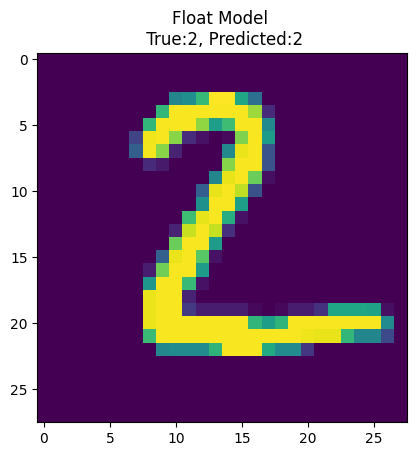

In [13]:
test_model(tflite_model_file, test_image_index, model_type="Float")

And test the quantized model:

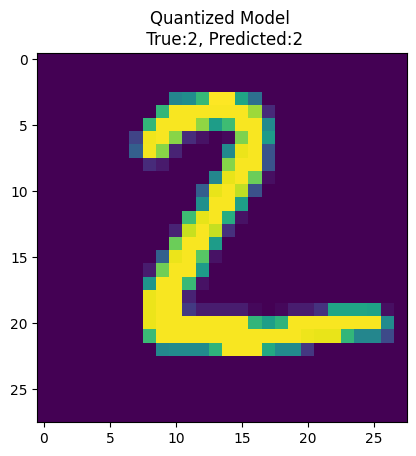

In [14]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

### Evaluate the models on all images

Now let's run both models using all the test images we loaded at the beginning of this tutorial:

In [15]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

Evaluate the float model:

In [16]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 97.9700% (Number of test samples=10000)


Evaluate the quantized model:

In [17]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 97.9000% (Number of test samples=10000)


So you now have an integer quantized a model with almost no difference in the accuracy, compared to the float model.

To learn more about other quantization strategies, read about [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).